In [1]:
using StateSpaceDynamics, Plots

In [16]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.95 0.05; 0.05 0.95], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.8638325554843976; 0.8638325

In [17]:
T = 200
# Generate synthetic data
x, y, z = sample(model, T)


([0.12781148406102946 -0.4355143368251308 … 0.909404203159019 0.33436564157211945; 0.3788281101630884 -0.21698572664429974 … -1.0322249266471213 1.0029556134436872], [-0.23695130919359814 0.19690226661132149 … -1.3364697080661 1.264127486591625; 0.6768781267756329 0.41107216802264435 … -1.0141890274016714 0.43649504800961036; … ; -0.7985358658347501 1.2320332201982314 … 0.9064441017981266 -2.1775597797660042; 0.35633628786769284 -1.54937097407612 … 0.30360016939733286 -0.8540978332134572], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

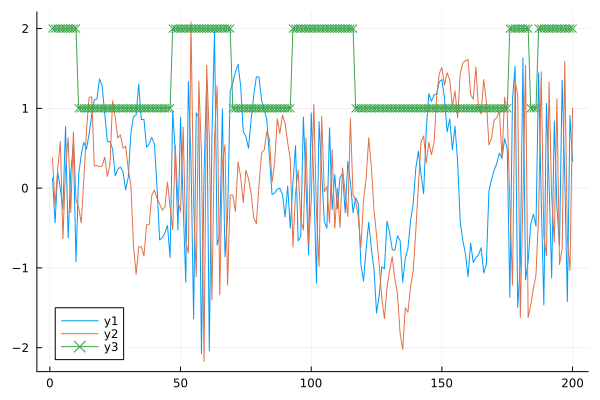

In [18]:
plot(x')
plot!(z, marker=:x)

Fit and get back posteriors

In [19]:
mls, param_diff, FB, FS = fit!(model, y; max_iter=1)

([-7216.593470291375], [0.0], StateSpaceDynamics.ForwardBackward{Float64}([-3.8737680948812545 -4.500844404004514 … -7.154222611034097 -5.922610019316858; -2.9154458890998076 -2.7053569296063023 … 4.532080917201103 1.831179257046176], [-4.413512046959072 -8.871981472170498 … 1524.9914830990324 1530.7038917217244; -3.789869132271122 -6.518700016084587 … 1539.6222256064339 1541.402111592384], [1542.554235870052 1545.879233231573 … -1.1564329188119928 0.0; 1545.1529149208538 1547.9084170879194 … 1.7799085473207783 0.0], [-3.261410354138661 -4.394882417829194 … -17.56708399701506 -10.698242455511036; -0.0390883886489064 -0.012417105396707484 … -2.3480879463022575e-8 -2.2584851421925123e-5], [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; … ;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0]), StateSpaceDynamics.FilterSmooth{Float64}[StateSpaceDynamics.FilterSmooth{Float64}([0.02352638701913524 -0.32018151938285044 … 0.33824734457709693 0.40532806703469476; 0.09382796

In [20]:
mls

1-element Vector{Float64}:
 -7216.593470291375

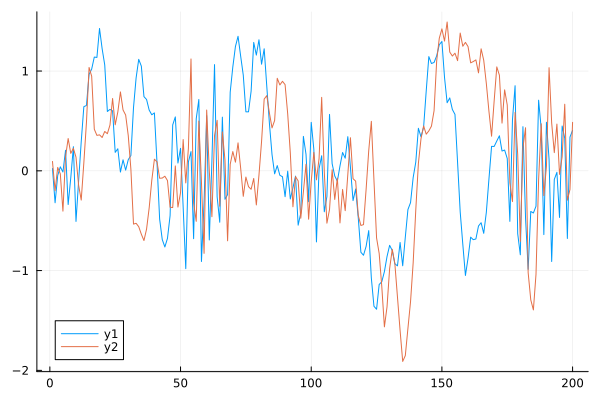

In [21]:
plot(FS[1].x_smooth')

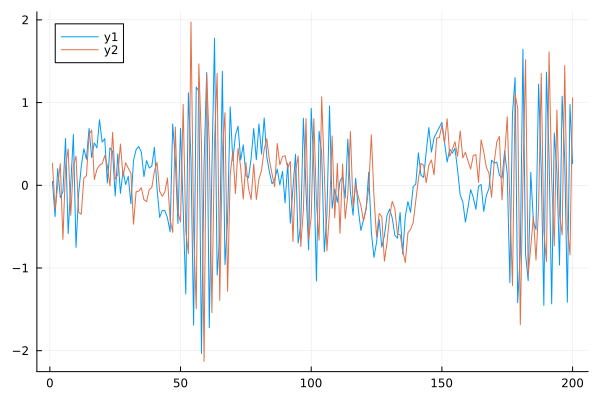

In [22]:
plot(FS[2].x_smooth')

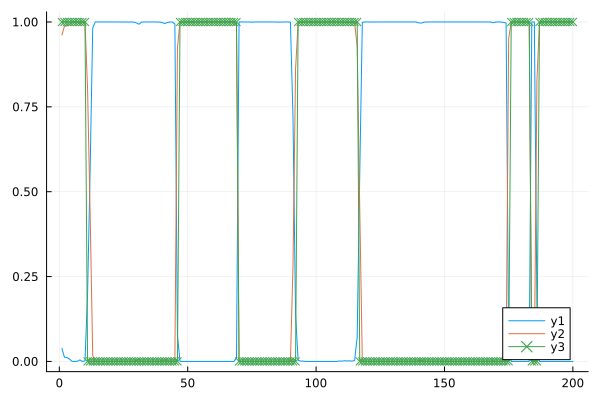

In [29]:
plot(exp.(FB.γ)')
plot!(z .- 1, marker=:x)

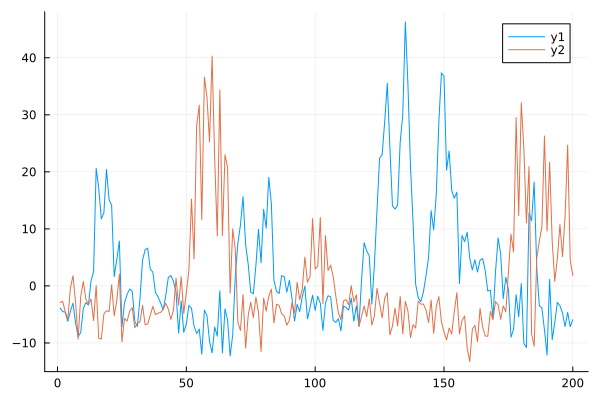

In [24]:
plot(FB.loglikelihoods')

In [26]:
exp(0.)

1.0

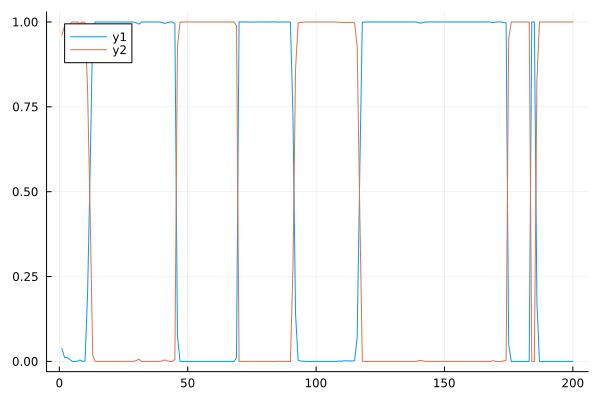

In [27]:
plot(exp.(FB.γ)')


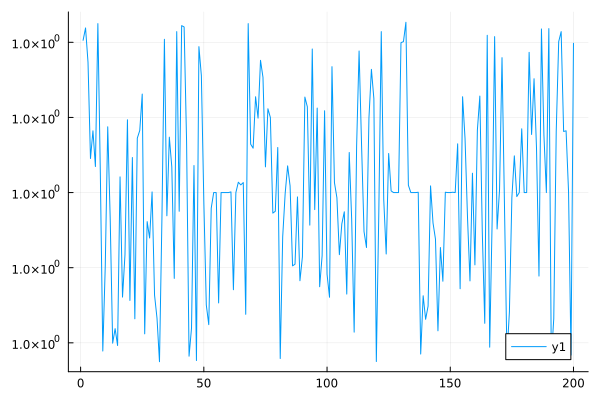

In [42]:
plot(sum(exp.(FB.γ), dims=1)')

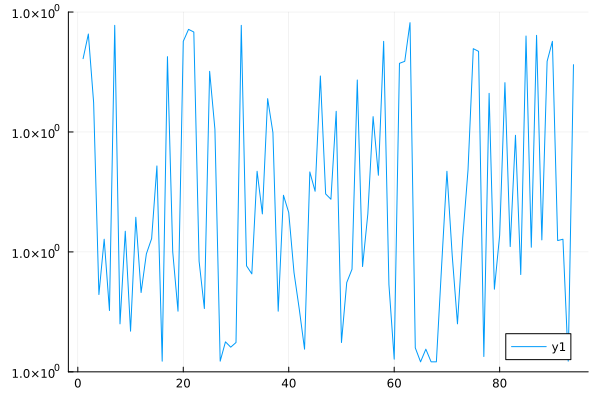

In [43]:
plot(blah[blah .> 1.0])

In [48]:
using HiddenMarkovModels

In [ ]:
smoothed_state_marginals, obs_seq_loglikelihood_fb = forward_backward(hmm, obs_seq);
